In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Specific tf libraries
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
# BOOST
import xgboost
import lightgbm


In [2]:
pd.options.mode.chained_assignment = None

In [3]:
%run ../common_utils.py

## 1 - BAGGING
Use the average of the predictions over the models, instead of using just one.
TODO:
- Try different models, and diferent combinations.
- Try to bag a stacking model

In [ ]:
# All their kaggle scores
d = {'LaureRF': 0.20015,
     'Deep': 0.23278,
     'GB': 0.19968,
     'CB1': 0.23450,
     'XGB1': 0.23787,
     'KNN1' : 0.35042}

acc = pd.DataFrame(
    d,
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

In [ ]:
LaureRF = pd.read_csv("ensemble_predictions/LaureRF.csv")
Deep = pd.read_csv("ensemble_predictions/Deep.csv")
GB = pd.read_csv("ensemble_predictions/GB.csv")
CB1 = pd.read_csv("ensemble_predictions/CB1.csv")
XGB1 = pd.read_csv("ensemble_predictions/XGB1.csv")
KNN1 = pd.read_csv("ensemble_predictions/KNN1.csv")

In [ ]:
LaureRF = LaureRF.sort_values(by="id")
Deep = Deep.sort_values(by="id")
GB = GB.sort_values(by="id")
CB1 = CB1.sort_values(by="id")
XGB1 = XGB1.sort_values(by="id")
KNN1 = KNN1.sort_values(by="id")

In [ ]:
LaureRF_prediction = LaureRF["price_prediction"].to_numpy().T
Deep_prediction = Deep["price_prediction"].to_numpy().T
GB_prediction = GB["price_prediction"].to_numpy().T
CB1_prediction = CB1["price_prediction"].to_numpy().T
XGB1_prediction = XGB1["price_prediction"].to_numpy().T
KNN1_prediction = KNN1["price_prediction"].to_numpy().T

In [ ]:
avg_prediction = np.average(
    [LaureRF_prediction,
     Deep_prediction,
     GB_prediction,
     CB1_prediction,
     XGB1_prediction,
     KNN1_prediction
    ],
    weights = 1 / acc['RMSLE'] ** 4,
    axis=0
)

In [ ]:
result = avg_prediction
submission = pd.DataFrame()
submission['id'] = LaureRF['id']
submission['price_prediction'] = result
if len(submission['id']) != 9937:
    raise Exception("Not enough rows submitted!")
submission.to_csv('BESTSUBMISSIONEVER', index=False)

In [89]:
kaggle_scores = [0.23450, 0.20502, 0.23278, 0.19968, 0.35042, 0.20015, 0.20159, 0.23787]
csv_paths = ["ensemble_predictions/csvs/CB1.csv", "ensemble_predictions/csvs/deep_king_5_5.csv", "ensemble_predictions/csvs/deep.csv", "ensemble_predictions/csvs/GB.csv",
             "ensemble_predictions/csvs/KNN1.csv", "ensemble_predictions/csvs/LaureRF.csv", "ensemble_predictions/csvs/xgb_king_2.csv", "ensemble_predictions/csvs/XGB1.csv"]
submission_path = "ensemble_predictions/bagging_1"

csv_bagging(kaggle_scores, csv_paths, submission_path)

## 2 - Stacking 🗼🗼
The more sofisticated way of ensemble the models.
Analogy: A king listening to advisors, and using their advise to make desicions.

In [4]:
%run ../common_utils.py

In [5]:
train, test, metaData = load_all_data()

### Deep learning advisor 🙌👍👍

In [6]:
# Mostly the ones correlated to price.
features =           ["building_id",
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True",  add_spacious=True, droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [7]:
model_params = ([18, 12, 6], tf.nn.relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True)

In [10]:
# NB! We cannot just compile ann model beforehand, will just keep training on same model.
ann_oof_train, ann_oof_test, hists = get_oof_ann(model_params, train_labels, train_targets, test_labels)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [11]:
# ADVISOR PERFORMANCE
for histories in hists:
    hist = pd.DataFrame(histories.history)
    hist['epoch'] = histories.epoch
    print(hist["val_loss"].tail(1))

399    0.223634
Name: val_loss, dtype: float64
399    0.232161
Name: val_loss, dtype: float64
399    0.208332
Name: val_loss, dtype: float64
399    0.223428
Name: val_loss, dtype: float64
399    0.247943
Name: val_loss, dtype: float64


In [33]:
print(np.sum(ann_oof_train >= 0) / len(ann_oof_train))
print(np.sum(ann_oof_test >= 0) / len(ann_oof_test))

1.0
1.0


### XGBoost advisor 😎😎

In [13]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True) # FALSE!

xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

minMax


In [14]:
xgb_oof_train, xgb_oof_test, scores = get_oof_xgboost(xgb_model, train_labels, np.log(train_targets), test_labels)

In [15]:
print(scores)

[0.21510740779427592, 0.20703188641213263, 0.17824608826778982, 0.2047050107177126, 0.235830623843561]


### lgbm advisor 🤢🤢

In [16]:
features = ['building_id', # Metadata
            'area_total', 'area_kitchen', 'area_living', 'floor','constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
            'latitude', 'longitude', # Numerical
            'district', # Categorical, but not one-hot encoded
            #'street','address', # String - removed for now
            'elevator_without', 'elevator_passenger', 'elevator_service', 'garbage_chute', 'windows_court', 'windows_street','new',  # Bool
            'seller', 'layout', 'condition', 'material', 'parking', 'heating' # Categorical, one-hot encoded
            ]
numerical_features = ['area_total', 'area_kitchen', 'area_living', 'floor',
                      'constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
                    'latitude', 'longitude']

cat_features = ['seller', 'layout', 'condition', 'material', 'parking', 'heating' ]

droptable = []

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) # FALSE!

Hot encoding
minMax


In [17]:
lgbm_model = lightgbm.LGBMRegressor(random_state=33, n_estimators=10000, verbose=-1)

In [18]:
lgbm_oof_train, lgbm_oof_test, scores = get_oof_lgbm(lgbm_model, train_labels, np.log(train_targets), test_labels)

c:\python\python38\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[122]	valid_0's l2: 0.0439833	valid_0's custom_asymmetric_eval: 0.0117378
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[234]	valid_0's l2: 0.0403438	valid_0's custom_asymmetric_eval: 0.011276
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[281]	valid_0's l2: 0.0309874	valid_0's custom_asymmetric_eval: 0.00979787
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[219]	valid_0's l2: 0.0412254	valid_0's custom_asymmetric_eval: 0.0111509
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[167]	valid_0's l2: 0.0514351	valid_0's custom_asymmetric_eval: 0.0127629


In [19]:
# Advisor performance
print(scores)

[0.20972204364505545, 0.20085759459841665, 0.17603243611263844, 0.2030403944812286, 0.22679309889342042]


### Add more advisors - RF 🌲🌲🎄🎄
https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package

In [20]:
features = ["building_id",
            "area_total", "latitude", "longitude", "floor", "stories", # Numerical
            "district", 'condition' # Categorical
           ]

numerical = [] # No need to scale for RF! https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
cat_features = []
droptable = []

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="none",
                    add_R=False, add_rel_height=False, add_spacious=False, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=False) 

In [21]:
rf_oof_train, rf_oof_test, scores = get_oof_rf(train_labels, train_targets, test_labels) # Use log() for RF?

In [22]:
print(scores)
print("==>\t",np.average(scores))

[0.2251182272114522, 0.259999816492946, 0.2225408508071664, 0.23420658091552532, 0.2983892759077355]
==>	 0.24805095026696508


### KNN Advisor 🏡🕺👨‍👨‍👧👮‍♂️🏠🏠🕺🏡👨‍🔧🏠👫🕺

In [23]:
features = ["building_id", # For Grouping
            "area_total", "ceiling", "floor", "bathrooms_shared", "balconies", "stories", "rooms","latitude","longitude", # Numerical
            "windows_street", "elevator_without", # Bool
            "parking", "heating", "district", "condition"  # Categorical
           ]

numerical_features = ["area_total", "ceiling", "floor", "bathrooms_shared", "balconies", "stories", "rooms"]
categorical_features = ["parking", "heating", "district", "condition"]
droptable=["latitude","longitude"]

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=False) 

Hot encoding
minMax


In [24]:
knn_oof_train, knn_oof_test, scores = get_oof_knn(train_labels, train_targets, test_labels)

c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

In [25]:
print(scores)
print("==>\t", np.average(scores))

[0.4702861431171438, 0.39298211278094125, 0.40469858030773803, 0.45785264431621453, 0.48577160617768994]
==>	 0.44231821733994553


### The XGB King! 🎩🎩

In [59]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) 

Hot encoding
minMax


In [60]:
xgb_king = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [61]:
# TODO: shouldn't xgb and lgbm predict the log(price)?
# NB! ann predicts some negative values! Maybe RELU on the output?
train_labels["xgb_preds"] = xgb_oof_train
train_labels["lgbm_preds"] = lgbm_oof_train
train_labels["ann_preds"] = np.log(ann_oof_train)
train_labels["knn_preds"] = np.log(knn_oof_train)
train_labels["rf_preds"] = np.log(rf_oof_train)

test_labels["xgb_preds"] = lgbm_oof_test
test_labels["lgbm_preds"] = xgb_oof_test
test_labels["ann_preds"] = np.log(ann_oof_test)
test_labels["knn_preds"] = np.log(knn_oof_test)
test_labels["rf_preds"] = np.log(rf_oof_test)

In [62]:
# Drop all except the good stuff?
train_labels.drop(train_labels.columns.to_list()[1:-5], inplace=True, axis=1)
test_labels.drop(test_labels.columns.to_list()[1:-5], inplace=True, axis=1)

In [64]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_king, train_labels, np.log(train_targets),
    eval_metric='rmse')

In [65]:
# Kings performance
print(scores)
print("==>", np.average(scores))

[0.21138299841770383, 0.20349600483072228, 0.17754018743509917, 0.20388134681147446, 0.23007838456797827]
==> 0.20527578441259559


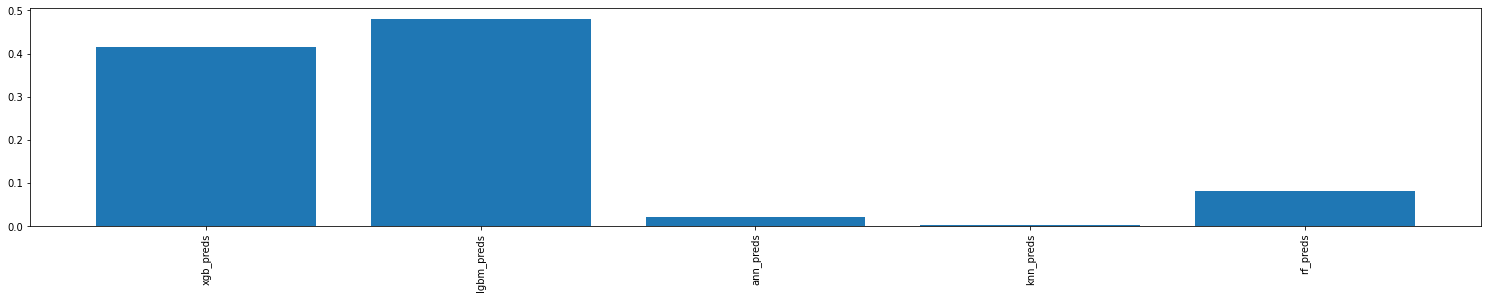

In [66]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), xgb_king.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [67]:
# Using all 5 advisors, and every other feature as well. xgb_king_1
# xgb_king_2; removes all but the predictions
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="ensemble_predictions/xgb_king_2", exponential=True)

### What about an ANN king? 🎩🎩

In [34]:
%run ../common_utils.py

In [35]:
# Mostly the ones correlated to price.
features =           ["building_id",
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True",  add_spacious=True, droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [36]:
train_labels["xgb_preds"] = np.exp(xgb_oof_train)
train_labels["lgbm_preds"] = np.exp(lgbm_oof_train)
train_labels["ann_preds"] = ann_oof_train
train_labels["knn_preds"] = knn_oof_train
train_labels["rf_preds"] = rf_oof_train

test_labels["xgb_preds"] = np.exp(lgbm_oof_test)
test_labels["lgbm_preds"] = np.exp(xgb_oof_test)
test_labels["ann_preds"] = ann_oof_test
test_labels["knn_preds"] = knn_oof_test
test_labels["rf_preds"] = rf_oof_test

In [37]:
# Drop all except the good stuff?
train_labels.drop(train_labels.columns.to_list()[1:-5], inplace=True, axis=1)
test_labels.drop(test_labels.columns.to_list()[1:-5], inplace=True, axis=1)

In [38]:
## TODO! Use a deeper net, with regularization maybe :D
model_params = ([18, 18, 18], tf.nn.leaky_relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True)

In [39]:
ann_scores, models, best_model, hists = ANN_groupKFold(5, model_params, train_labels, train_targets)


...........................................................................Epoch 00075: early stopping
New best model!

...............................................................Epoch 00063: early stopping

....................................................Epoch 00052: early stopping
New best model!

.........................................Epoch 00041: early stopping

....................................................................Epoch 00068: early stopping


In [40]:
print(ann_scores)
print("==>\t", np.average(ann_scores))

[0.1852976232767105, 0.18717044591903687, 0.15437853336334229, 16.474166870117188, 0.19578523933887482]
==>	 3.43935974240303


,loss,mse,msle,accuracy,val_loss,val_mse,val_msle,val_accuracy,epoch
66,0.187477,1.614198e+14,0.037160,0.0,0.195575,2.207648e+14,0.056483,0.0,66
67,0.187364,1.608416e+14,0.037057,0.0,0.195785,2.187477e+14,0.056272,0.0,67


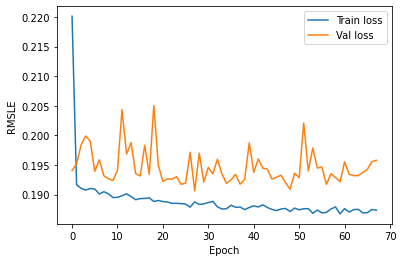

In [58]:
# Results
history = hists[4]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.loc[hist["val_loss"]==hist["val_loss"].min()]
display(hist.tail(2))
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
#plt.yscale("log")
plt.plot(hist['epoch'], hist['loss'], label='Train loss')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

In [43]:
# deep_king_1: uses same features as deep advisor, and same model type as 8_4.
# deep_king_2: is the same, just re-running deep_advisor for better score. NB: deleted...
# deep_king_3: Is deeper, and wider, and adds regularizations. Is worse. - NB! Also used leaky relu! Three tings were added: depth, regularization and leaky => worse!
# deep_king_4: removes regularization, is a little less wide (64)        - NB! Also used leaky relu! Regularization was removed: improved slightly!
# deep_king_5: removes all other than the pre-trained ones!              - Completely different test. Made a lot of copies.

In [44]:
predict_and_store(best_model, #models[4],
                  test_labels.drop(["building_id"], axis=1), test, path="ensemble_predictions/deep_king_5_5", exponential=False)

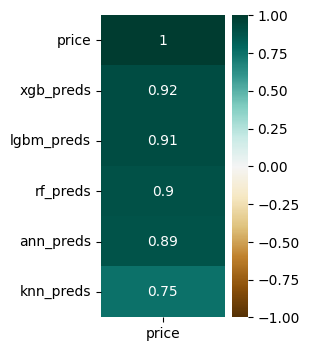

In [88]:
f, ax = plt.subplots(figsize=(2, 4), dpi=100)
heatmap = sns.heatmap(pd.merge(np.exp(train_labels.drop(["building_id"], axis=1)), train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

### todo:
- Use some advisors that havent seen area total.
- Train one advisor for each feature.

In [91]:
total_hours = [79, 49, 120, 111, 122, 99, 93, 111, 138, 137]
weeks = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
mean = np.ones(len(weeks))*np.mean(total_hours)

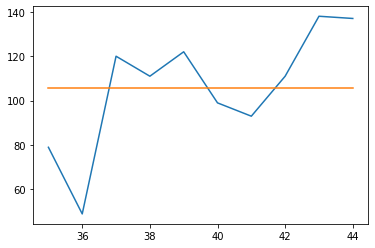

In [93]:
plt.plot(weeks, total_hours)
plt.plot(weeks, mean)
plt.show()

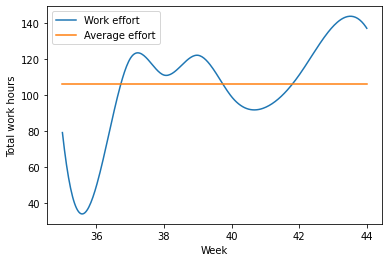

In [105]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(min(weeks), max(weeks), 300)  

spl = make_interp_spline(weeks, total_hours, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth, label="Work effort")
plt.plot(xnew, np.ones(len(xnew))*np.mean(total_hours), label="Average effort")
plt.xlabel("Week")
plt.ylabel("Total work hours")
plt.legend()
plt.savefig('overall_work_graph.png')
plt.show()